Plot LSLA effects on the baseline trajectories/categorizations

In [1]:
import  plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pickle
from collections import OrderedDict
from math import pi
import brewer2mpl
from mpl_toolkits.axes_grid1 import ImageGrid


# styles = plot_style.create() # get the plotting styles
# styles['plot_type'] = 'paper'
# plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-white')
# plt.style.use(styles['paper'])

In [2]:
exp_name = 'trajectories_const_farmland'
lsla_exp_name = ''
cats = ['S+E+','S+E-','S-E+','S-E-']

In [3]:
# import the model data
all_mods = pickle.load(open('../../outputs/{}/{}lsla_all_models.pkl'.format(exp_name, lsla_exp_name), 'rb'))

In [4]:
scenarios = list(all_mods.keys())
mod_names = list(all_mods[scenarios[0]].keys())
outputs = list(all_mods[scenarios[0]][mod_names[0]].keys())
nreps = len(all_mods[scenarios[0]][mod_names[0]][outputs[0]])
outputs

['has_livestock', 'sufficient_income', 'som', 'grass']

In [5]:
scenarios

['baseline',
 'displ. to farms',
 'displ. to commons',
 'LSLA in commons',
 'outgrower']

In [6]:
all_mods[scenarios[4]][mod_names[2]][outputs[3]][0]

array([0.98448703, 0.97219923, 0.96137426, 0.95142699, 0.94294255,
       0.93504325, 0.94264999, 0.96693302, 0.95523036, 0.94586822,
       0.93767635, 0.93036218, 0.92392572, 0.91807438, 0.91251561,
       0.90754198, 0.90315348, 0.89935011, 0.89583931, 0.89262108,
       0.88940284, 0.90052038, 0.96429992, 0.97161409, 0.97571003,
       0.96488506, 0.96956612, 0.98829039, 0.98448703, 0.97219923,
       0.97629516])

In [7]:
# format the data
# average outputs over ALL models and replications
formatted_data = OrderedDict()
for s, sc in enumerate(scenarios):
    formatted_data[sc] = OrderedDict()
    for c, cat in enumerate(cats):
        formatted_data[sc][cat] = {}
        for o, output in enumerate(outputs):
            # loop over all models in this category
            mod_data = []
            for mod_name, mi in all_mods[sc].items():
                if mod_name[0]==str(c):
                    mod_data.append(mi[output]) # append if it's the correct category
            
            axx = (0,1) if output=='grass' else (0,1,3) # (mod,rep,year,agent)->(year) (grass has no agent)
            formatted_data[sc][cat][output] = np.mean(np.array(mod_data), axis=axx) # dimension --> (year)

## Trajectories averaged over all models

In [8]:
formatted_data[scenarios[2]][cats[1]][outputs[0]]

array([0.8902  , 0.942525, 0.956975, 0.941975, 0.9269  , 0.856575,
       0.8563  , 0.838225, 0.83005 , 0.813725, 0.806575, 0.799075,
       0.7982  , 0.797075, 0.791025, 0.7881  , 0.7879  , 0.7867  ,
       0.785875, 0.780475, 0.755625, 0.771375, 0.77445 , 0.772625,
       0.770675, 0.75915 , 0.7668  , 0.753625, 0.75505 , 0.747525])

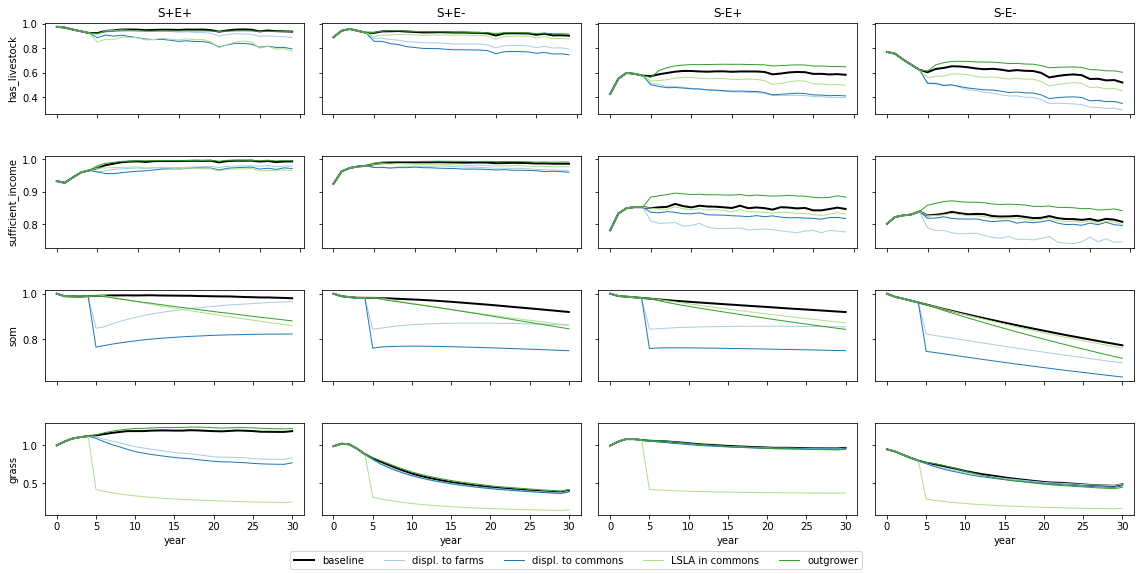

In [9]:
colors = brewer2mpl.get_map('Paired', 'Qualitative', len(scenarios)-1).mpl_colors
fig, ax_all = plt.subplots(5,4,figsize=(16,8),gridspec_kw={'height_ratios':[1,1,1,1,0.05]},
                          sharey='row')
axs = ax_all[:-1]
[axi.remove() for axi in ax_all[-1]]
fax = axs.flatten()
for c, cat in enumerate(cats):
    for o, output in enumerate(outputs):
        color_ix = 0
        for s, sc in enumerate(scenarios):
            if sc=='baseline':
                color='k'
                lw=2
            else:
                color = colors[color_ix]
                color_ix += 1
                lw=1
                
            axs[o,c].plot(formatted_data[sc][cat][output], color=color, lw=lw, ls='-')
    
# formatting
for a, axi in enumerate(axs[:,0]):
    axi.set_ylabel(outputs[a])
for a, axi in enumerate(fax):
    axi.grid(False)
#     axi.set_xticklabels([])
for a, axi in enumerate(axs[-1]):
    axi.set_xlabel('year')
for a, axi in enumerate(axs[0:-1].flatten()):
    axi.set_xticklabels([])
for a, axi in enumerate(axs[0]):
    axi.set_title(cats[a])

fig.legend(scenarios, ncol=len(scenarios), bbox_to_anchor=(0.5,0.0), loc=8)
fig.tight_layout()
fig.savefig('../../outputs/{}/{}lsla_trajectories.png'.format(exp_name, lsla_exp_name), dpi=200)

## probability of changing class under each LSLA scenario

In [10]:
# format the data -- changes in categories
# store results as probabilities
threshs = [0.5,0.8]

# format the data
classes = OrderedDict()
for s, sc in enumerate(scenarios):
    classes[sc] = OrderedDict()
    for c, cat in enumerate(cats):
        classes[sc][str(c)] = []
    for mod_name, mi in all_mods[sc].items():
        # classify this model
        s1 = np.mean(np.array(mi['has_livestock']), axis=(1,2)) > threshs[0] # mean over (year,agent)
        s2 = np.mean(np.array(mi['sufficient_income']), axis=(1,2)) > threshs[0] # mean over (year,agent)
        e1 = np.mean(np.array(mi['som'])[:,-1], axis=(1)) > threshs[1] # mean over agent in last year
        e2 = np.min(np.array(mi['grass']), axis=(1)) > threshs[1] # min over (year)
        s_plus = s1*s2
        e_plus = e1*e2
        mod_cats = np.full(s_plus.shape[0], np.nan)
        mod_cats[s_plus*e_plus] = 0
        mod_cats[s_plus*~e_plus] = 1
        mod_cats[~s_plus*e_plus] = 2
        mod_cats[~s_plus*~e_plus] = 3
        classes[sc][mod_name[0]].append(mod_cats)
        
# calculate probabilities
probs = OrderedDict()
for s, sc in enumerate(scenarios):
    probs[sc] = np.full([4,4], np.nan) # matrix of transition probs
    for c, cat in enumerate(cats):
        tmp = np.array(classes[sc][str(c)])
        for c2 in np.arange(4):
            probs[sc][c,c2] = np.mean(tmp==c2)

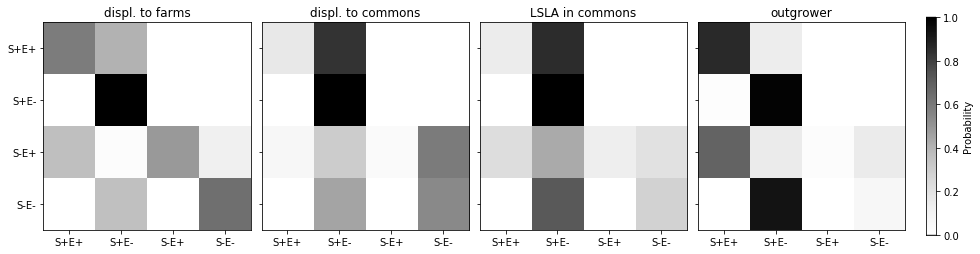

In [12]:
# plot
sc_plot = np.array(scenarios)[np.array(scenarios)!='baseline']
n_plot = len(sc_plot)
fig = plt.figure(figsize=(4*n_plot,4))
axs = ImageGrid(fig, 111, nrows_ncols=(1,n_plot),
    axes_pad=0.15, add_all=True, label_mode='L',
    cbar_mode='single',cbar_location='right', aspect=False,
    cbar_pad='10%', direction='row')
for s, sc in enumerate(sc_plot):
    hm = axs[s].imshow(probs[sc], vmin=0, vmax=1, cmap='Greys')
    axs[s].set_title(sc)
    
    axs[s].set_xticks(np.arange(4))
    axs[s].set_xticklabels(cats)

axs[0].set_yticks(np.arange(4))
axs[0].set_yticklabels(cats)

cax = axs.cbar_axes[0]
cbar = cax.colorbar(hm)
axis = cax.axis[cax.orientation]
axis.label.set_text("Probability")
fig.savefig('../../outputs/{}/{}lsla_class_changes.png'.format(exp_name, lsla_exp_name), dpi=200)